## 선형 회귀를 활용해 유의한 데이터 식별
- 관심 변수의 분포에 덜 의존적
- 일변량/이변량 분석에서보다 더 많은 것을 고려함
- 통계 모델링에서만 식별할 수 있는 이상값 존재
- 목적: 다변량 분석에 과도한 영향을 끼칠 수 있는 이상값이 존재하는가?

### statsmodels의 OLS 메소드로 선형 회귀 모델 피팅

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

covidtotals=pd.read_csv('C:/data-cleansing-main/Chapter04/data/covidtotals.csv')
covidtotals.set_index('iso_code',inplace=True)
covidtotals

,lastdate,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds
iso_code,,,,,,,,,,,
AFG,2020-06-01,Afghanistan,15205,257,390.589,6.602,38928341.0,54.422,18.6,1803.987,0.50
ALB,2020-06-01,Albania,1137,33,395.093,11.467,2877800.0,104.871,38.0,11803.431,2.89
DZA,2020-06-01,Algeria,9394,653,214.225,14.891,43851043.0,17.348,29.1,13913.839,1.90
AND,2020-06-01,Andorra,764,51,9888.048,660.066,77265.0,163.755,NaN,NaN,NaN
AGO,2020-06-01,Angola,86,4,2.617,0.122,32866268.0,23.890,16.8,5819.495,NaN
...,...,...,...,...,...,...,...,...,...,...,...
VNM,2020-06-01,Vietnam,328,0,3.370,0.000,97338583.0,308.127,32.6,6171.884,2.60
ESH,2020-06-01,Western Sahara,23,1,38.505,1.674,597330.0,NaN,28.4,NaN,NaN
YEM,2020-06-01,Yemen,323,80,10.829,2.682,29825968.0,53.508,20.3,1479.147,0.70


In [2]:
xvars=['pop_density','median_age','gdp_per_capita']
covidanalysis=covidtotals.loc[:,['total_cases_pm']+xvars].dropna()      # 누락 데이터 드롭
covidanalysis.describe()

,total_cases_pm,pop_density,median_age,gdp_per_capita
count,175.000000,175.000000,175.000000,175.000000
mean,1134.015709,247.151863,30.537143,19008.385423
std,2101.363772,822.398967,9.117751,19673.386571
min,0.000000,1.980000,15.100000,661.240000
25%,67.448000,36.066000,22.300000,4458.202500
50%,263.413000,82.328000,29.700000,12951.839000
75%,1357.506000,207.960000,38.700000,27467.146000
max,19753.146000,7915.731000,48.200000,116935.600000


In [4]:
# 백만 명당 총 확진자 수의 예측변수일 것으로 예상되는 컬럼 활용(인구밀도, 중위연령 등)
def getlm(df):
    Y=df.total_cases_pm
    X=df[['pop_density','median_age','gdp_per_capita']]
    X=sm.add_constant(X)
    return sm.OLS(Y,X).fit()

In [5]:
lm=getlm(covidanalysis)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_cases_pm   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     61.81
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           4.06e-27
Time:                        16:36:35   Log-Likelihood:                -1522.4
No. Observations:                 175   AIC:                             3053.
Df Residuals:                     171   BIC:                             3065.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            944.4731    426.712      2.213      0.028     102.172    1786.774
pop_density       -0.2057      0.142     -1.447      0.150      -0.486       0.075
median_age       -49.4398     16.013     -3.088      0.002     -81.048     -17.832
gdp_per_capita     0.0921      0.008     12.015      0.000       0.077       0.107
==============================================================================
Omnibus:                      105.361   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1182.641
Skew:                           1.967   Prob(JB):                    1.56e-257
Kurtosis:                      15.113   Cond. No.                     1.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Cook's Distance
- 모델에 큰 영향을 미치는 국가 식별
- 쿡 거리가 0.5보다 크다면 조사 필요

In [10]:
influence=lm.get_influence().summary_frame()
influence.loc[influence.cooks_d>0.5,['cooks_d']]

,cooks_d
iso_code,
HKG,0.780662
QAT,5.080180


In [11]:
covidanalysis.loc[influence.cooks_d>0.5]

,total_cases_pm,pop_density,median_age,gdp_per_capita
iso_code,,,,
HKG,0.000,7039.714,44.8,56054.92
QAT,19753.146,227.322,31.9,116935.60


### influence plot 그리기
- 쿡 거리 값이 높은 국가를 큰 원으로 그린다.

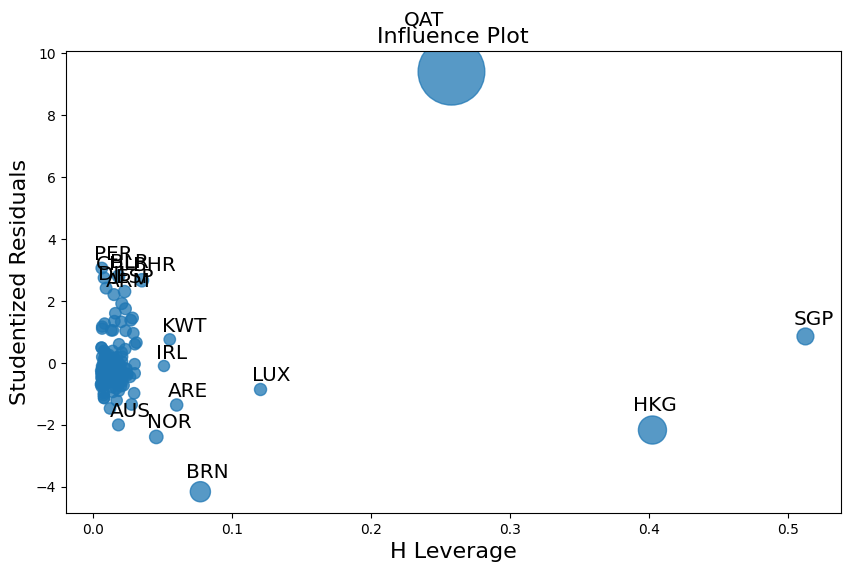

In [12]:
fig,ax=plt.subplots(figsize=(10,6))
sm.graphics.influence_plot(lm,ax=ax,criterion='cooks')
plt.show()

### 특정 국가를 제외하고 모델링
- 카타르를 제외하고 수행하면 극적인 효과가 있음

In [14]:
covidanalysisminusoutliers=covidanalysis.loc[influence.cooks_d<0.5]     # 쿡 거리가 0.5 미만인 국가들로만 데이터프레임 생성

lm=getlm(covidanalysisminusoutliers)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_cases_pm   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     46.56
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           5.52e-22
Time:                        16:56:43   Log-Likelihood:                -1464.8
No. Observations:                 173   AIC:                             2938.
Df Residuals:                     169   BIC:                             2950.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             44.0854    349.924      0.126      0.900    -646.700     734.870
pop_density        0.2423      0.145      1.666      0.098      -0.045       0.529
median_age        -2.5165     13.526     -0.186      0.853     -29.217      24.184
gdp_per_capita     0.0557      0.007      7.875      0.000       0.042       0.070
==============================================================================
Omnibus:                       53.262   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.935
Skew:                           1.347   Prob(JB):                     1.22e-27
Kurtosis:                       6.152   Cond. No.                     1.01e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 그런데 저 지표들을 보고 판단할 능력이 부족함 ㅠ

## 정리
OLS 메소드로 선형 회귀 모델 피팅 -> cook's distance가 0.5보다 큰 국가 탐색 -> influence plot을 통해 cook's distance 시각적으로 확인 -> 카타르 제외 후 피팅